In [1]:
%matplotlib inline


Finetuning Torchvision Models
=============================

**Author:** `Nathan Inkawhich <https://github.com/inkawhich>`__




In [2]:
!pip install validators

In [3]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
!pip install -q wandb
import wandb

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

torch.manual_seed(3407)
np.random.seed(3407)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [4]:
!nvidia-smi

Mon Feb 14 12:51:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Inputs
------

Here are all of the parameters to change for the run. We will use the
*hymenoptera_data* dataset which can be downloaded
`here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`__.
This dataset contains two classes, **bees** and **ants**, and is
structured such that we can use the
`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset, rather than writing our own custom dataset. Download the data
and set the ``data_dir`` input to the root directory of the dataset. The
``model_name`` input is the name of the model you wish to use and must
be selected from this list:

::

   [resnet, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




In [5]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"

# Number of classes in the dataset
num_classes = 101

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 30

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

Helper Functions




In [6]:
def train_model(
        model, dataloaders, criterion, optimizer,
        scheduler=None, num_epochs=25, is_inception=False
    ):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    wandb.init(project="turtles")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            wandb.log({
                "epoch":epoch,
                f"loss_{phase}":epoch_loss,
                f"acc_{phase}":epoch_acc,
            })
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Initialize and Reshape the Networks
-----------------------------------


In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    elif model_name == "efficientnet":
        '''
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
        '''

        model_ft = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
        utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.fc.in_features
        model_ft.classifier.fc = nn.Linear(num_ftrs, num_classes) 
        input_size = 380
    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size


# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [9]:
import os

SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './turtle_recall/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


In [10]:
import pandas as pd
import requests
import io
import urllib.parse

BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))


# Read in csv files.
train = read_csv_from_web('train.csv')
test = read_csv_from_web('test.csv')
sample_submission = read_csv_from_web('sample_submission.csv')

all_ids = np.unique(train.turtle_id)

extra = read_csv_from_web('extra_images.csv')
mask = extra.turtle_id.isin(all_ids)
extra.turtle_id[~mask] = "new_turtle"
train = pd.concat((train, extra[mask]))
train = pd.concat((train, extra[~mask].sample(100)))
# Convert image_location strings to lowercase.
# for df in [train, test]:
#   df.image_location = df.image_location.apply(lambda x: x.lower())
#   assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

In [11]:
train.head(), train.shape

(      image_id image_location      turtle_id
 0  ID_2RK4WLN8            top  t_id_VP2NW7aV
 1  ID_VVW0QXLX           left  t_id_qZ0iZYsC
 2  ID_RVATH2HZ          Right  t_id_3b65X5Lw
 3  ID_2GB90GPS           left  t_id_YjXYTCGC
 4  ID_LM6S0B1M            top  t_id_d6aYXtor, (2884, 3))

In [12]:
# plt.plot(train.groupby('turtle_id').count())
# (train['turtle_id']=="new_turtle").sum()

In [13]:
idx2id = train["turtle_id"].unique()
id2idx = {v : i for i, v in enumerate(idx2id)}

In [14]:
train_size = int(train.shape[0] * 0.9)
train = train.sample(train.shape[0])
train, val = train[:train_size], train[train_size:]
train.shape, val.shape

((2595, 3), (289, 3))

In [15]:
from torchvision.io import read_image

class TurtleDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        img = read_image(f"{IMAGE_DIR}/{self.df.iloc[idx]['image_id']}.JPG") / 255.
        # img = (img - 127.5) / 128.
        # pad_h = max(img.size(1), img.size(2)) - img.size(1)
        # pad_w = max(img.size(1), img.size(2)) - img.size(2)
        # img = torch.nn.functional.pad(img, (0, pad_w, 0, pad_h, 0, 0))
        img = self.transforms(img.float())
        
        label = id2idx[self.df.iloc[idx]['turtle_id']]
        return img, label
td = TurtleDataset(train, lambda x: x)
len(td), td[300];

In [16]:
# Data augmentation and normalization for training
# Just normalization for validation
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         # transforms.RandomAffine(degrees=(0, 70), translate=(0.1, 0.11), scale=(0.75, 0.99)),
#         # transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))]),
#         # transforms.TrivialAugmentWide(),
#         # transforms.ToTensor(),
#         transforms.Resize(3*input_size//2),
#         transforms.RandomCrop(input_size),
#         # transforms.Normalize([0.5, 0.5, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
#         # transforms.ToTensor(),
#         # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomAffine(degrees=(0, 70), translate=(0.1, 0.11), scale=(0.75, 0.99)),
        transforms.RandomResizedCrop(input_size, scale=(0.5, 1.)),
        transforms.RandomHorizontalFlip(),
        # transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        # transforms.RandomResizedCrop(input_size, scale=(0.5, 1.)),
        # transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: TurtleDataset(train if x == 'train' else val, data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.117904 2.0250773


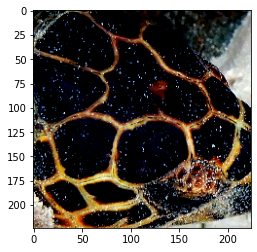

In [17]:
for imgs, labels in dataloaders_dict['train']:
    for img in imgs:
        print(np.min(img.numpy()), np.max(img.numpy()))
        plt.imshow((img.numpy().transpose(1, 2, 0) + 1) / 2)
        plt.show()
        break
    break

Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [18]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            # print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            # print("\t",name)
            pass

# Observe that all parameters are being optimized
# optimizer_ft = optim.AdamW(params_to_update, lr=0.001)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler_ft = None # optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.001, steps_per_epoch=len(dataloaders_dict['train']), epochs=num_epochs)

Params to learn:


Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [19]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_ft, hist = train_model(
    model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler_ft,
    num_epochs=num_epochs, is_inception=(model_name=="inseption")
)

wandb: Currently logged in as: kostyayatsok (use `wandb login --relogin` to force relogin)


Epoch 0/29
----------
train Loss: 4.2911 Acc: 0.0740
val Loss: 3.8179 Acc: 0.1557

Epoch 1/29
----------
train Loss: 3.4586 Acc: 0.2046
val Loss: 3.0743 Acc: 0.2388

Epoch 2/29
----------
train Loss: 2.6955 Acc: 0.3618
val Loss: 2.3308 Acc: 0.4464

Epoch 3/29
----------
train Loss: 2.1070 Acc: 0.4987
val Loss: 1.9040 Acc: 0.5329

Epoch 4/29
----------
train Loss: 1.6141 Acc: 0.6200
val Loss: 1.6256 Acc: 0.5813

Epoch 5/29
----------
train Loss: 1.2823 Acc: 0.7152
val Loss: 1.3822 Acc: 0.6644

Epoch 6/29
----------
train Loss: 1.0252 Acc: 0.7761
val Loss: 1.1081 Acc: 0.7301

Epoch 7/29
----------
train Loss: 0.7969 Acc: 0.8378
val Loss: 1.0254 Acc: 0.7266

Epoch 8/29
----------
train Loss: 0.6198 Acc: 0.8786
val Loss: 0.8825 Acc: 0.7924

Epoch 9/29
----------
train Loss: 0.5076 Acc: 0.9064
val Loss: 0.9007 Acc: 0.7924

Epoch 10/29
----------
train Loss: 0.4024 Acc: 0.9341
val Loss: 0.7905 Acc: 0.8235

Epoch 11/29
----------
train Loss: 0.3187 Acc: 0.9530
val Loss: 0.7834 Acc: 0.8166

Ep

Comparison with Model Trained from Scratch
------------------------------------------

Just for fun, lets see how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.




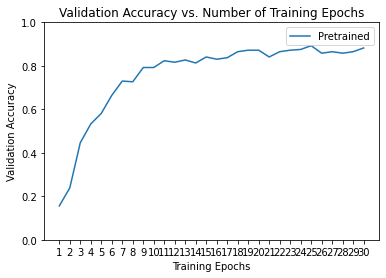

In [20]:
# Initialize the non-pretrained version of the model used for this run
# scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
# scratch_model = scratch_model.to(device)
# scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
# scratch_criterion = nn.CrossEntropyLoss()
# _,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
# shist = []

ohist = [h.cpu().numpy() for h in hist]
# shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
# plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

  0%|          | 0/490 [00:00<?, ?it/s]

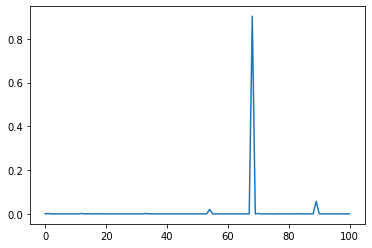

 10%|▉         | 48/490 [00:03<00:27, 15.86it/s]

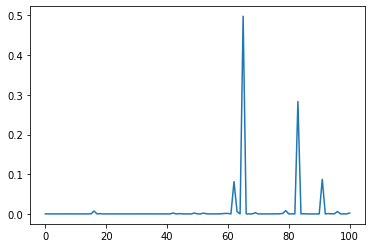

 20%|█▉        | 97/490 [00:06<00:27, 14.45it/s]

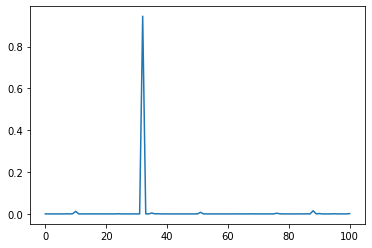

 30%|███       | 147/490 [00:09<00:24, 14.16it/s]

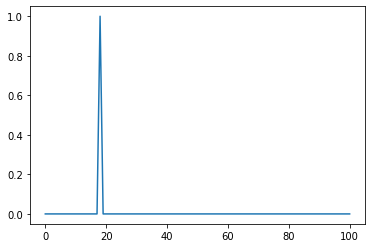

 40%|███▉      | 195/490 [00:12<00:19, 15.13it/s]

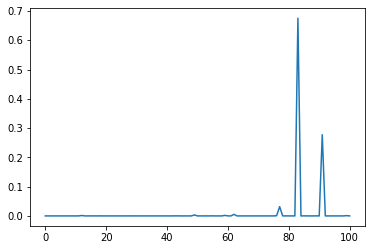

 50%|████▉     | 243/490 [00:16<00:14, 16.69it/s]

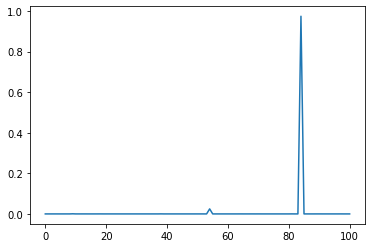

 60%|█████▉    | 293/490 [00:19<00:13, 14.83it/s]

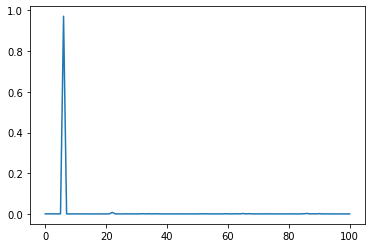

 70%|██████▉   | 342/490 [00:23<00:09, 16.03it/s]

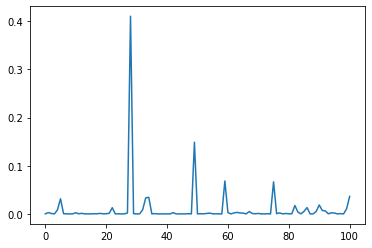

 80%|███████▉  | 391/490 [00:26<00:06, 15.06it/s]

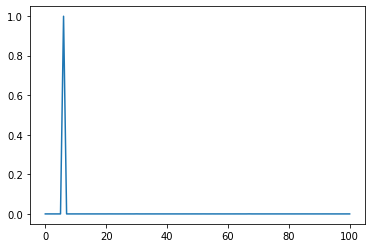

 90%|████████▉ | 440/490 [00:29<00:03, 14.84it/s]

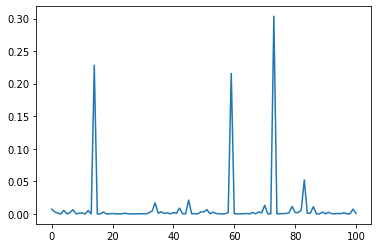

100%|██████████| 490/490 [00:33<00:00, 14.52it/s]


,image_id,image_location,prediction1,prediction2,prediction3,prediction4,prediction5
0,ID_6NEDKOYZ,top,t_id_4ZfTUmwL,t_id_KysHzQQK,t_id_uJXT7dGu,t_id_2Yn71r7R,t_id_FBsGDJhU
1,ID_57QZ4S9N,left,t_id_Kf73l69A,t_id_NW7wn8TC,t_id_HcnnlRda,t_id_m2JvEcsg,t_id_gz3whk0q
2,ID_OCGGJS5X,left,t_id_YjXYTCGC,t_id_ROFhVsy2,t_id_G5JLzvai,t_id_UVQa4BMz,t_id_pCO59rOk
3,ID_R2993S3S,top,t_id_pCO59rOk,t_id_HxxqrdTx,t_id_0DPPpRUz,t_id_9GFmcOd5,t_id_2QmcRkNj
4,ID_2E011NB0,left,t_id_dVQ4x3wz,t_id_DPYQnZyv,t_id_YjXYTCGC,t_id_g9Fz8PH7,t_id_2E8o5Jtl
...,...,...,...,...,...,...,...
485,ID_0RVNUKK1,left,t_id_D7NA71la,t_id_dVQ4x3wz,t_id_8b8sprYe,t_id_n2FBHk6d,t_id_AOWArhGb
486,ID_6405IKG3,top,t_id_Imm5pnNf,t_id_4XiPKIk7,t_id_87CLFCvE,t_id_J5dngbNA,t_id_uVgs53Cz
487,ID_6WVPVB7S,right,t_id_iD9ikw6Y,t_id_p77GDtzg,t_id_MwnEYfqe,t_id_B7LaSiac,t_id_WDCMGvI4
488,ID_47C5LL2G,right,t_id_hRzOoJ2t,t_id_7gFFZy7i,t_id_dVQ4x3wz,t_id_IP3xtKuX,t_id_JI6ba2Yx


In [21]:
from tqdm import tqdm
model_ft.eval()
for i in range(5):
    test[f'prediction{i+1}'] = ""

with torch.no_grad():
    for i_row, row in tqdm(test.iterrows(), total=sample_submission.shape[0]):
        img_raw = read_image(f"{IMAGE_DIR}/{row['image_id']}.JPG") / 255.
        img_raw = img_raw.to(device)
        
        total_out = torch.zeros((101))
        img = data_transforms['val'](img_raw)
        out = model_ft(img.unsqueeze(0))[0]
        out = torch.softmax(out, axis=-1).cpu()
        total_out += out
        
        if i_row % 49 == 0:
            plt.plot(total_out)
            plt.show()
        
        val, idxs = torch.topk(total_out, 5)
        for i, idx in enumerate(idxs):
            row[f'prediction{i+1}'] = idx2id[idx]
test

In [22]:
from google.colab import files

test.drop(columns=['image_location']).to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
pd.read_csv("submission.csv")

,image_id,prediction1,prediction2,prediction3,prediction4,prediction5
0,ID_6NEDKOYZ,t_id_4ZfTUmwL,t_id_KysHzQQK,t_id_uJXT7dGu,t_id_2Yn71r7R,t_id_FBsGDJhU
1,ID_57QZ4S9N,t_id_Kf73l69A,t_id_NW7wn8TC,t_id_HcnnlRda,t_id_m2JvEcsg,t_id_gz3whk0q
2,ID_OCGGJS5X,t_id_YjXYTCGC,t_id_ROFhVsy2,t_id_G5JLzvai,t_id_UVQa4BMz,t_id_pCO59rOk
3,ID_R2993S3S,t_id_pCO59rOk,t_id_HxxqrdTx,t_id_0DPPpRUz,t_id_9GFmcOd5,t_id_2QmcRkNj
4,ID_2E011NB0,t_id_dVQ4x3wz,t_id_DPYQnZyv,t_id_YjXYTCGC,t_id_g9Fz8PH7,t_id_2E8o5Jtl
...,...,...,...,...,...,...
485,ID_0RVNUKK1,t_id_D7NA71la,t_id_dVQ4x3wz,t_id_8b8sprYe,t_id_n2FBHk6d,t_id_AOWArhGb
486,ID_6405IKG3,t_id_Imm5pnNf,t_id_4XiPKIk7,t_id_87CLFCvE,t_id_J5dngbNA,t_id_uVgs53Cz
487,ID_6WVPVB7S,t_id_iD9ikw6Y,t_id_p77GDtzg,t_id_MwnEYfqe,t_id_B7LaSiac,t_id_WDCMGvI4
488,ID_47C5LL2G,t_id_hRzOoJ2t,t_id_7gFFZy7i,t_id_dVQ4x3wz,t_id_IP3xtKuX,t_id_JI6ba2Yx


Final Thoughts and Where to Go Next
-----------------------------------

Try running some of the other models and see how good the accuracy gets.
Also, notice that feature extracting takes less time because in the
backward pass we do not have to calculate most of the gradients. There
are many places to go from here. You could:

-  Run this code with a harder dataset and see some more benefits of
   transfer learning
-  Using the methods described here, use transfer learning to update a
   different model, perhaps in a new domain (i.e. NLP, audio, etc.)
-  Once you are happy with a model, you can export it as an ONNX model,
   or trace it using the hybrid frontend for more speed and optimization
   opportunities.


